In [1872]:
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning)
warnings.filterwarnings(action='ignore', category=FutureWarning)

import numpy as np
import math
import pandas as pd
import itertools

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 30)
#pd.options.display.float_format = '{:,}'.format 





In [1873]:
def enum_category(label):
    num=0
    if label == 'Poor' : num =1
    elif label == 'Fair': num = 2
    elif label == 'Average': num = 3
    elif label == 'Good': num = 4
    elif label == 'Very Good': num = 5
    else: return label
    
    return int(num)

def log_and_normalize (data, log, norm_type):
    if log == 'log':
        data = np.log(data) 
    if norm_type == 1:
        data = (data-np.mean(data))/np.std(data)  # std normalisation
    elif norm_type == 2:
        data = (data-min(data))/(max(data)-min(data))      #  min_max_min
    elif norm_type == 3:
        data = (data-np.mean(data))/(max(data)-min(data))  # mean norm
    
    return data    

def hot_encode (data, directions):
    if directions == 'yes':
        data = pd.get_dummies(data, prefix=data.name[:3], drop_first=True)
    return data

In [1874]:
df=pd.read_csv('data/kc_house_data.csv', index_col=0)

# initial cleaning operations (dropping columns, splitting , etc)
df.drop(columns=["waterfront",'view'],inplace=True)
df["grade"]=df["grade"].map(lambda x: x.split()[0]).astype(int)
df['condition'] = df['condition'].apply(enum_category)




In [2003]:
# Prepairing data
df.drop(df.index[df["bedrooms"]==33], inplace=True)

df['renovated']=np.where((df['yr_renovated'].isna() |  df['yr_renovated'] == 0), 0, 1)
df['yr_renovated'].fillna(value=df['yr_built'],inplace=True)
df['yr_renovated'] = np.where(df['yr_renovated'] == 0, df['yr_built'], df['yr_renovated'])

#df['sqft_basement'].replace('?', '0', inplace=True)
df=df[df['sqft_basement'] != '?']
df['sqft_basement']=df['sqft_basement'].astype(float).astype(int)



#df['sqft_basement'] = np.where((df['sqft_basement'] < 100) & (df['sqft_basement'] > -1), 1, df['sqft_basement'])
#df['sqft_basement']=np.where((df['sqft_basement']==-1) & (df['sqft_living']-df['sqft_above']<=400), 
#                             1, df['sqft_basement'])
#df['sqft_basement']=np.where((df['sqft_basement']==-1) & (df['sqft_living']-df['sqft_above']>400) 
#                             & (df['sqft_above']/df['sqft_living']<0.70),
#                             (df['sqft_living']-df['sqft_above'])*0.75/df['floors'], df['sqft_basement'])
#df['sqft_basement'] = np.where (df['sqft_basement'] == -1, 1, df['sqft_basement'])



#NEW FEATURES

df["age"]=2016-df['yr_built']
df["years_after_renovation"]=2016-df['yr_renovated']
df['month_of_sale']=df['date'].apply(lambda x: str.split(x,'/')[0]).astype(int)

df['after_1980']= np.where(df['yr_built'] <= 1980, 0, 1)
df['basement']= np.where(df['sqft_basement'] < 50, 0, 1)

#FILTER

df=df[df['yr_built']>1981]

df['lat_range']=pd.cut(df['lat'], 30)
df['long_range']=pd.cut(df['long'], 30)
df['coord_range']=np.array(zip(df['lat_range'],df['long_range']))

df['coord_range'].nunique()


355

In [2004]:
#num=df.select_dtypes(include=[np.number]).drop("price", axis=1)

cont=["sqft_living", 'sqft_lot']
cat=[ "grade",  'bedrooms',  'floors', 'condition','yr_built','after_1980','renovated','coord_range']


#cont=["sqft_living"]
#cat=[ 'grade', 'coord_range', 'bedrooms']



data_fin=pd.DataFrame([])
price=df[["price"]]
asis=[['basement']]

In [2005]:
# Log transform and normalize
for col in cont:
    data_fin[col]=log_and_normalize(df[col], 'log', 0)

#data_fin["sqft_living"]=log_and_normalize(df["sqft_living"], 'log', 0)
#data_fin["lat"]=log_and_normalize(df["lat"], 'nolog', 0)
#data_fin["yr_built"]=log_and_normalize(df["yr_built"], 'nolog', 0)
price=log_and_normalize(df["price"], 'log', 0)

In [2006]:
# One hot encode categoricals
for col in cat:
    new_cols=hot_encode(df[col], 'yes')
    data_fin = pd.concat([data_fin, new_cols], axis=1)


In [2007]:
data_fin = pd.concat([price, data_fin], axis=1)

#pd.plotting.scatter_matrix(data_fin,figsize  = [14, 14]);


In [2008]:
pd.options.display.float_format = '{:,}'.format 

pred=data_fin.drop(columns=["price"]).copy()



pred_int = sm.add_constant(pred)
model = sm.OLS(price,pred_int).fit()
model.summary()





<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.927
Model:                            OLS   Adj. R-squared:                  0.923
Method:                 Least Squares   F-statistic:                     252.4
Date:                Sat, 26 Mar 2022   Prob (F-statistic):               0.00
Time:                        19:16:23   Log-Likelihood:                 4986.9
No. Observations:                8638   AIC:                            -9144.
Df Residuals:                    8223   BIC:                            -6212.
Df Model:                         414                                         
Covariance Type:            nonrobust                                         
================================================================================================================================================================
                                                                                                   coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------------------------------------------
const                                                                                            8.1642      0.175     46.706      0.000       7.822       8.507
sqft_living                                                                                      0.5427      0.009     60.310      0.000       0.525       0.560
sqft_lot                                                                                         0.0888      0.003     27.942      0.000       0.083       0.095
gra_6                                                                                           -0.4114      0.070     -5.892      0.000      -0.548      -0.275
gra_7                                                                                           -0.3785      0.068     -5.545      0.000      -0.512      -0.245
gra_8                                                                                           -0.3070      0.068     -4.484      0.000      -0.441      -0.173
gra_9                                                                                           -0.2211      0.069     -3.221      0.001      -0.356      -0.087
gra_10                                                                                          -0.1283      0.069     -1.860      0.063      -0.264       0.007
gra_11                                                                                           0.0161      0.070      0.232      0.817      -0.120       0.152
gra_12                                                                                           0.1915      0.071      2.687      0.007       0.052       0.331
gra_13                                                                                           0.3804      0.088      4.333      0.000       0.208       0.552
bed_2                                                                                           -0.0106      0.031     -0.342      0.732      -0.072       0.050
bed_3                                                                                           -0.0114      0.031     -0.365      0.715      -0.072       0.050
bed_4                                                                                           -0.0195      0.032     -0.617      0.537      -0.081       0.042
bed_5                                                                                           -0.0329      0.032     -1.022      0.307      -0.096       0.030
bed_6                                                                                           -0.0311      0.037     -0.840      0.401      -0.104       0.041
bed_7                   

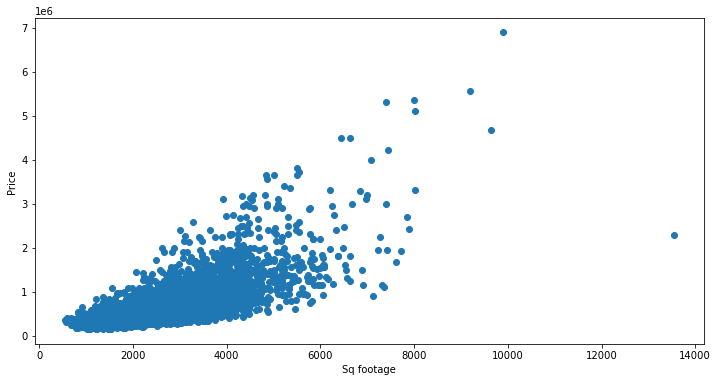

In [2009]:
sales_pred = model.predict()
sales_pred
plt.figure(figsize=(12, 6))
plt.plot(df['sqft_living'], df['price'], 'o')  
#plt.plot(pred_int['sqft_living'], sales_pred, 'r', linewidth=2)
plt.xlabel('Sq footage')
plt.ylabel('Price')
plt.show()

In [2019]:
results=[]
combs=data_fin.drop("price", axis=1).columns
#combs=num
for comb in itertools.combinations(combs, 1):
    test=data_fin[list(comb)].copy()
    prep = sm.add_constant(test[list(comb)])
    model = sm.OLS(price, prep).fit()
    results.append([comb, model.rsquared_adj])

pd.DataFrame(results).sort_values(1, ascending=False)



,0,1
0,"(sqft_living,)",0.5229529988202981
3,"(gra_7,)",0.25727861463369994
6,"(gra_10,)",0.14626736944466356
7,"(gra_11,)",0.14405861229872174
1,"(sqft_lot,)",0.09355097259829603
...,...,...
126,"(coo_(Interval(47.345, 47.365, closed='right')...",-0.00011571968923829168
356,"(coo_(Interval(47.675, 47.695, closed='right')...",-0.00011572251278524348
301,"(coo_(Interval(47.592, 47.613, closed='right')...",-0.0001157663054363045
49,"(yr__2005,)",-0.0001157942965253067


In [2020]:
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
linreg.fit(pred,price)
linreg.score(pred, price)

0.9270495493657194

In [2028]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

pred_train, pred_test, price_train, price_test = train_test_split(pred, price, test_size=0.2)

In [2029]:
linreg = LinearRegression()
linreg.fit(pred_train, price_train)
linreg.score(pred_train, price_train)

0.9272968101229414

In [2030]:
y_train = linreg.predict(pred_train)
y_test = linreg.predict(pred_test)

In [2031]:
train_residuals = y_train - price_train
test_residuals = y_test - price_test

In [2032]:
mse_train = np.sum((price_train-y_train)**2)/len(price_train)
mse_test = np.sum((price_test-y_test)**2)/len(price_test)
print('Train Mean Squarred Error:', mse_train)
print('Test Mean Squarred Error:', mse_test)

Train Mean Squarred Error: 0.01836283855481603
Test Mean Squarred Error: 1.5485599574351844e+18


In [2033]:
mse_train

0.01836283855481603

In [2034]:
train_mse = mean_squared_error(price_train, y_train)
test_mse = mean_squared_error(price_test, y_test)
print('Train Mean Squarred Error:', train_mse)
print('Test Mean Squarred Error:', test_mse)

Train Mean Squarred Error: 0.01836283855481603
Test Mean Squarred Error: 1.5485599574351844e+18
